In [ ]:
# import packages, libraries
import pandas as pd
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

from google.colab import drive

In [ ]:

### Connect with google drive
def connect_and_fetch_train():

  drive.mount('/content/drive')

  ### Train & Test csv dir

  train_file = "1aFLIETCp08ZRwvYj29MPeHokzltUywhv"
  test_file = "1wB9wtBDqedOlLeVfnaMY0b_oTXmu3rg4"


  train_dir = f'https://drive.google.com/uc?id={train_file}'
  return train_dir

def connect_and_fetch_test():
  drive.mount('/content/drive')

  ### Train & Test csv dir

  test_file = "1wB9wtBDqedOlLeVfnaMY0b_oTXmu3rg4"


  test_dir = f'https://drive.google.com/uc?id={test_file}'
  return test_dir

In [711]:
df_train = pd.read_csv(connect_and_fetch_train())
df_test = pd.read_csv(connect_and_fetch_test())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [712]:

df_train.isnull().sum()


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [713]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB



# Data Visualization

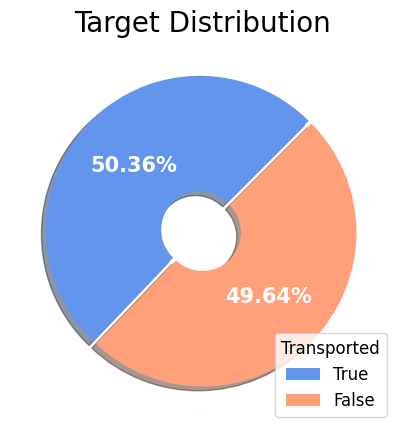

In [714]:
fig, ax = plt.subplots(figsize=(5,5))

labels = df_train["Transported"].value_counts().index
lst = df_train["Transported"].value_counts().to_list()
pie = ax.pie(lst, labels = labels, autopct='%.2f%%', textprops=dict(color="white", fontsize=15, weight="bold"), colors=["cornflowerblue", "lightsalmon"], shadow=True, wedgeprops=dict(width=0.75), startangle=45, explode=(0.025,0))

ax.set_title("Target Distribution", size=20)
ax.legend(title="Transported", title_fontsize=12, loc='best', fontsize=12)
plt.show()

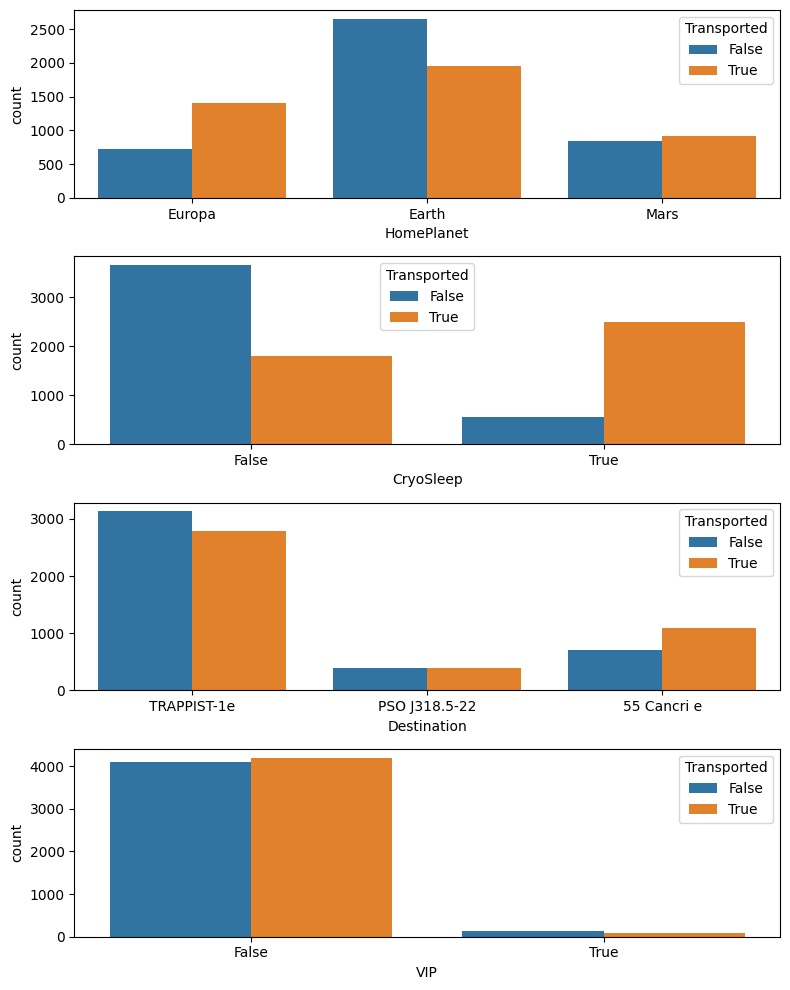

In [715]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(8,10))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=df_train, x=var_name, axes=ax, hue='Transported')

fig.tight_layout()  # Improves appearance a bit
plt.show()

# Preprocessing


In [716]:
def split_cabin(df):
  df[['deck','num','side']]=df['Cabin'].str.split('/',expand=True)

  return df

df_train = split_cabin(df_train)
df_test = split_cabin(df_test)


In [717]:
df_train['Name'].fillna('Unknown', inplace=True)
df_test['Name'].fillna('Unknown', inplace=True)

df_train['Surname'] = df_train['Name'].str.split(' ').str[1]
df_test['Surname'] = df_test['Name'].str.split(' ').str[1]

In [718]:

df_train['Family'] = df_train['PassengerId'].str.split('_').str[0]

df_test['Family'] = df_test['PassengerId'].str.split('_').str[0]

In [719]:
df_train['Surname'] = df_train.groupby(['Family'])['Surname'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
df_test['Surname'] = df_test.groupby(['Family'])['Surname'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

<Axes: xlabel='deck', ylabel='HomePlanet'>

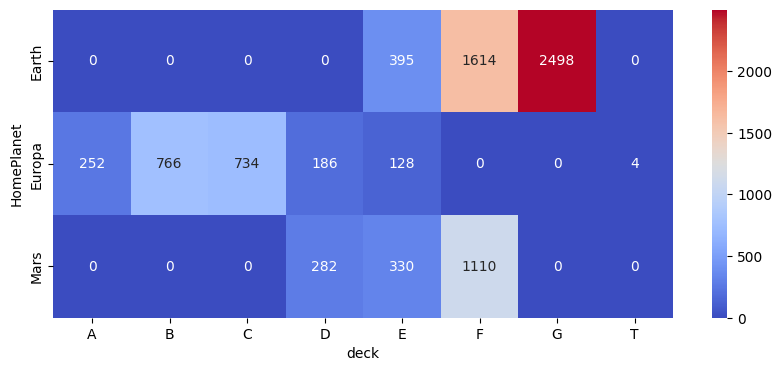

In [720]:
homePlanet_cabin=df_train.groupby(['deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(homePlanet_cabin.T, annot=True, fmt='g', cmap='coolwarm')

In [721]:
df_train.loc[df_train['deck'].isin(['A', 'B', 'D']), 'HomePlanet'] = 'Europa'
df_train.loc[df_train['deck']=='G', 'HomePlanet'] = 'Earth'


In [722]:
df_train[df_train['Destination'].isna()].groupby(['Family', 'Surname'])['Destination'].size().reset_index(name='MissingCount')

,Family,Surname,MissingCount
0,0045,Chmad,1
1,0138,Gambs,1
2,0152,Estron,1
3,0382,Floydendley,1
4,0462,Sosanturney,1
...,...,...,...
175,8956,Bonnondry,1
176,9130,Corte,1
177,9195,Purle,1
178,9197,Platch,1


In [723]:
# Some issues
# def missing_features_related_family(df, features):
#   for feature in features:
#     df[feature] = df.groupby(['Family'])[feature].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
#   return df
# df_train['HomePlanet'] = df_train.groupby(['Family'])['HomePlanet'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# df_test['HomePlanet'] = df_test.groupby(['Family'])['HomePlanet'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
# df_train['Cabin'] = df_train.groupby(['Family'])['Cabin'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# df_test['Cabin'] = df_test.groupby(['Family'])['Cabin'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# df_train['Destination'] = df_train.groupby(['Family'])['Destination'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# df_test['Destination'] = df_test.groupby(['Family'])['Destination'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

In [724]:
# Filter rows with non-null 'HomePlanet'
non_null_homeplanet = df_train[df_train['HomePlanet'].notnull()]

# Create a dictionary mapping 'Family' to non-null 'HomePlanet' values
family_homeplanet_map = dict(zip(non_null_homeplanet['Family'], non_null_homeplanet['HomePlanet']))

# Fill NaN values in 'HomePlanet' using the mapped values
df_train['HomePlanet'] = df_train['Family'].map(family_homeplanet_map)



In [725]:
# Filter rows with non-null 'HomePlanet'
non_null_destination = df_train[df_train['Destination'].notnull()]

# Create a dictionary mapping 'Family' to non-null 'HomePlanet' values
family_destination_map = dict(zip(non_null_homeplanet['Family'], non_null_destination['Destination']))

# Fill NaN values in 'HomePlanet' using the mapped values
df_train['Destination'] = df_train['Family'].map(family_destination_map)


In [726]:
df_train['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [727]:
# Filter rows with non-null 'Cabin'
non_null_cabin = df_train[df_train['Cabin'].notnull()]

# Create a dictionary mapping 'Family' to non-null 'HomePlanet' values
family_homeplanet_map = dict(zip(non_null_homeplanet['Family'], non_null_cabin['Cabin']))

# Fill NaN values in 'HomePlanet' using the mapped values
df_train['Cabin'] = df_train['Family'].map(family_homeplanet_map)




In [728]:
label_cols = ["HomePlanet", "CryoSleep","deck","side", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(df_train,df_test ,label_cols)

In [729]:
df_train["side"].mode()

0    1
Name: side, dtype: int64

# Feature Engineering


In [730]:
def preprocessing_missing_value(df):
  df['Destination'].fillna(df['Destination'].mode()[0], inplace=True)
  df['CryoSleep'].fillna(df['CryoSleep'].mode()[0], inplace=True)
  df['RoomService'].fillna(df['RoomService'].min(), inplace=True)
  df['FoodCourt'].fillna(df['FoodCourt'].mean(), inplace=True)
  df['VIP'].fillna(df['VIP'].mode()[0],inplace = True)
  df['Age'].fillna(df['Age'].mode()[0],inplace = True)
  df['Spa'].fillna(df['Spa'].mean(), inplace = True)
  df['VRDeck'].fillna(df['VRDeck'].mean(), inplace = True)
  df['ShoppingMall'].fillna(df['ShoppingMall'].mean(), inplace = True)
  df['HomePlanet'].fillna(df['HomePlanet'].mode()[0],inplace = True)
  df['deck'].fillna(df['deck'].mode()[0],inplace = True)
  df['side'].fillna(df['side'].mode()[0],inplace = True)
  df['num'].fillna(df['num'].median(), inplace = True)
  df['num'] = df['num'].astype('int')
  return df

df_train = preprocessing_missing_value(df_train)
df_test = preprocessing_missing_value(df_test)


In [731]:
df_train['Age'].mode()[0]

24.0

In [732]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scr=StandardScaler()
minn=MinMaxScaler()


def scaling(df):
  df["FoodCourt"]= minn.fit_transform(df[["FoodCourt"]])
  df["RoomService"]= minn.fit_transform(df[["RoomService"]])
  df["ShoppingMall"]= minn.fit_transform(df[["ShoppingMall"]])
  df["Spa"]= minn.fit_transform(df[["Spa"]])
  df["Age"]= minn.fit_transform(df[["Age"]])
  df["VRDeck"]= scr.fit_transform(df[["VRDeck"]])
  df["num"]= scr.fit_transform(df[["num"]])

  return df
df_train = scaling(df_train)
df_test = scaling(df_test)
# add new row

df_train


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,Surname,Family
0,0001_01,1,0,B/0/P,2,0.493671,0,0.000000,0.000000,0.000000,0.000000,-0.269023,Maham Ofracculy,False,1,-1.177238,0,Ofracculy,0001
1,0002_01,0,0,F/0/S,2,0.303797,0,0.007608,0.000302,0.001064,0.024500,-0.230194,Juanna Vines,True,5,-1.177238,1,Vines,0002
2,0003_01,1,0,A/0/S,2,0.734177,1,0.003001,0.119948,0.000000,0.299670,-0.225782,Altark Susent,False,0,-1.177238,1,Susent,0003
3,0003_02,1,0,A/0/S,2,0.417722,0,0.000000,0.043035,0.015793,0.148563,-0.098708,Solam Susent,False,0,-1.177238,1,Susent,0003
4,0004_01,0,0,F/1/S,2,0.202532,0,0.021149,0.002348,0.006428,0.025214,-0.267258,Willy Santantines,True,5,-1.175264,1,Santantines,0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0,NaN,3,0.518987,1,0.000000,0.228726,0.000000,0.073322,-0.203720,Gravior Noxnuther,False,0,-0.983795,0,Noxnuther,9276
8689,9278_01,0,1,NaN,3,0.227848,0,0.000000,0.000000,0.000000,0.000000,-0.269023,Kurta Mondalley,False,6,1.781653,1,Mondalley,9278
8690,9279_01,0,0,NaN,3,0.329114,0,0.000000,0.000000,0.079687,0.000045,-0.269023,Fayey Connon,True,6,1.783627,1,Connon,9279
8691,9280_01,1,0,NaN,3,0.405063,0,0.000000,0.035186,0.000000,0.015753,2.585740,Celeon Hontichre,False,4,0.022899,1,Hontichre,9280


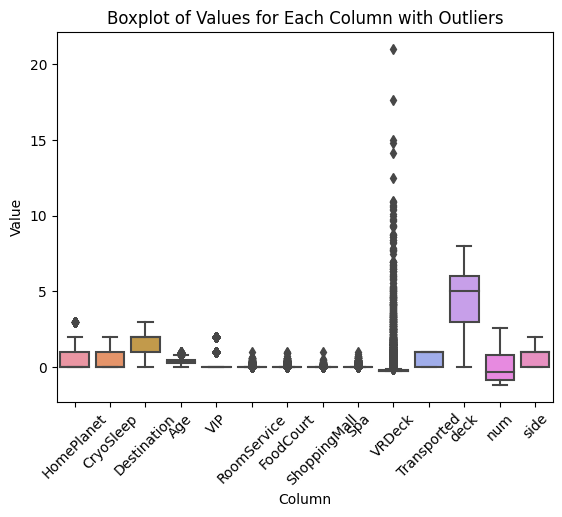

In [733]:

#plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train, fliersize=5)  # Set fliersize to highlight outliers
plt.title('Boxplot of Values for Each Column with Outliers')
plt.xlabel('Column')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [734]:
df_train[df_train['Age']<0]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,Surname,Family


In [735]:
#applying pca , here i want reduce to 4 columns to 2 columns which are roomservice foodcourt shoppingmall and spa.
from sklearn.decomposition import PCA
def reducecolpca(df):
  selected_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa']
  data = df[selected_columns]
  n_components = 2  #number of new columns pca
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(data)
  pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
  df["pca_price"]=pc_df['PC1']
  df["pca_pricee"]=pc_df['PC2']
  return df

df_train = reducecolpca(df_train)
df_test = reducecolpca(df_test)
df_train.drop(['RoomService','FoodCourt','ShoppingMall','Spa'],axis=1,inplace=True)

In [736]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  8693 non-null   object 
 1   HomePlanet   8693 non-null   int64  
 2   CryoSleep    8693 non-null   int64  
 3   Cabin        8494 non-null   object 
 4   Destination  8693 non-null   int64  
 5   Age          8693 non-null   float64
 6   VIP          8693 non-null   int64  
 7   VRDeck       8693 non-null   float64
 8   Name         8693 non-null   object 
 9   Transported  8693 non-null   bool   
 10  deck         8693 non-null   int64  
 11  num          8693 non-null   float64
 12  side         8693 non-null   int64  
 13  Surname      8589 non-null   object 
 14  Family       8693 non-null   object 
 15  pca_price    8693 non-null   float64
 16  pca_pricee   8693 non-null   float64
dtypes: bool(1), float64(5), int64(6), object(5)
memory usage: 1.1+ MB


In [737]:
# df_train["pca_price"]=pc_df['PC1']
# df_train["pca_pricee"]=pc_df['PC2']

# df_train.drop(['RoomService','FoodCourt','ShoppingMall','Spa'],axis=1,inplace=True)

In [738]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,VRDeck,Name,Transported,deck,num,side,Surname,Family,pca_price,pca_pricee
0,0001_01,1,0,B/0/P,2,0.493671,0,-0.269023,Maham Ofracculy,False,1,-1.177238,0,Ofracculy,0001,-0.020387,-0.014960
1,0002_01,0,0,F/0/S,2,0.303797,0,-0.230194,Juanna Vines,True,5,-1.177238,1,Vines,0002,-0.005536,0.001201
2,0003_01,1,0,A/0/S,2,0.734177,1,-0.225782,Altark Susent,False,0,-1.177238,1,Susent,0003,0.255494,0.070966
3,0003_02,1,0,A/0/S,2,0.417722,0,-0.098708,Solam Susent,False,0,-1.177238,1,Susent,0003,0.103240,0.031565
4,0004_01,0,0,F/1/S,2,0.202532,0,-0.267258,Willy Santantines,True,5,-1.175264,1,Santantines,0004,-0.003678,0.013039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0,NaN,3,0.518987,1,-0.203720,Gravior Noxnuther,False,0,-0.983795,0,Noxnuther,9276,0.206472,-0.049637
8689,9278_01,0,1,NaN,3,0.227848,0,-0.269023,Kurta Mondalley,False,6,1.781653,1,Mondalley,9278,-0.020387,-0.014960
8690,9279_01,0,0,NaN,3,0.329114,0,-0.269023,Fayey Connon,True,6,1.783627,1,Connon,9279,-0.020526,-0.011429
8691,9280_01,1,0,NaN,3,0.405063,0,2.585740,Celeon Hontichre,False,4,0.022899,1,Hontichre,9280,0.017200,-0.018557


In [739]:
df_test.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
deck              0
num               0
side              0
Surname          51
Family            0
pca_price         0
pca_pricee        0
dtype: int64

In [740]:
df_train.isnull().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin          199
Destination      0
Age              0
VIP              0
VRDeck           0
Name             0
Transported      0
deck             0
num              0
side             0
Surname        104
Family           0
pca_price        0
pca_pricee       0
dtype: int64

In [741]:
df_train.drop(["Surname","Name","Cabin"],axis=1,inplace=True)

# Model Selection



In [742]:
# train and test split
X = df_train.drop(columns=['Transported','PassengerId'])
y = df_train['Transported']



In [753]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [754]:
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


def print_confusion_matrix(confusion_matrix):
  f, ax=plt.subplots(figsize=(5,5))
  sns.heatmap(confusion_matrix,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
  plt.xlabel("y_pred")
  plt.ylabel("y_true")
  plt.show()
def models_on_training(X_train, y_train):

  # Train KNeighborsClassifier Model
  KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
  KNN_Classifier.fit(X_train, y_train);

  # Train LogisticRegression Model
  LGR_Classifier = LogisticRegression(n_jobs=-1)
  LGR_Classifier.fit(X_train, y_train);

  #Train Gaussian Naive Baye Model
  BNB_Classifier = BernoulliNB()
  BNB_Classifier.fit(X_train, y_train)

  # Train Decision Tree Model
  DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
  DTC_Classifier.fit(X_train, y_train)

  # Train RandomForest
  rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_classifier.fit(X_train, y_train)



  models = []
  models.append(('Naive Baye Classifier', BNB_Classifier))
  models.append(('Decision Tree Classifier', DTC_Classifier))
  models.append(('KNeighborsClassifier', KNN_Classifier))
  models.append(('LogisticRegression', LGR_Classifier))
  models.append(('Random Forest', rf_classifier))



  for i, v in models:
      scores = cross_val_score(v, X_train, y_train, cv=10)
      accuracy = metrics.accuracy_score(y_train, v.predict(X_train))
      confusion_matrix = metrics.confusion_matrix(y_train, v.predict(X_train))
      classification = metrics.classification_report(y_train, v.predict(X_train))
      print()
      print('============================== {} Model Evaluation =============================='.format(i))
      print()
      print ("Cross Validation Mean Score:" "\n", scores.mean())
      print()
      print ("Model Accuracy:" "\n", accuracy)
      print()
      print_confusion_matrix(confusion_matrix)
      print("Classification report:" "\n", classification)
      print()
  return models

In [755]:
def model_performance_in_test(models, X_test, y_test):
  for i, v in models:
    accuracy = metrics.accuracy_score(y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(y_test, v.predict(X_test))
    classification = metrics.classification_report(y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print_confusion_matrix(confusion_matrix)
    print()
    print("Classification report:" "\n", classification)
    print()


In [756]:
def pipeline(X_train, X_test, y_train, y_test):
  models = models_on_training(X_train, y_train)
  #model_performance_in_test(models, X_test, y_test)



============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.7435989828826594

Model Accuracy:
 0.7428817946505608



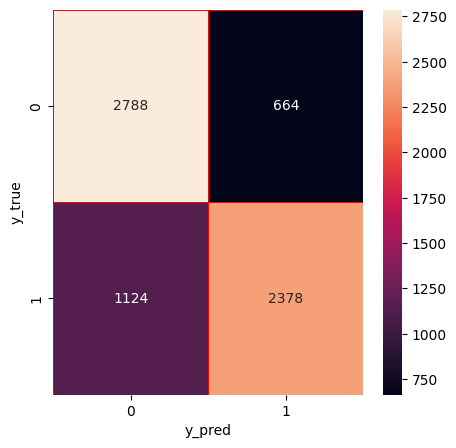

Classification report:
               precision    recall  f1-score   support

       False       0.71      0.81      0.76      3452
        True       0.78      0.68      0.73      3502

    accuracy                           0.74      6954
   macro avg       0.75      0.74      0.74      6954
weighted avg       0.75      0.74      0.74      6954



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.7456191598445382

Model Accuracy:
 0.999712395743457



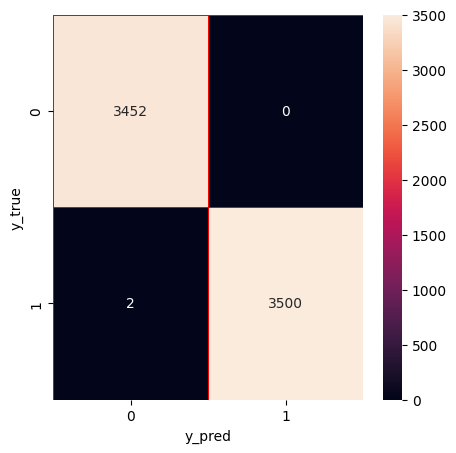

Classification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      3452
        True       1.00      1.00      1.00      3502

    accuracy                           1.00      6954
   macro avg       1.00      1.00      1.00      6954
weighted avg       1.00      1.00      1.00      6954



============================== KNeighborsClassifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.5349435623914662

Model Accuracy:
 0.7113891285591026



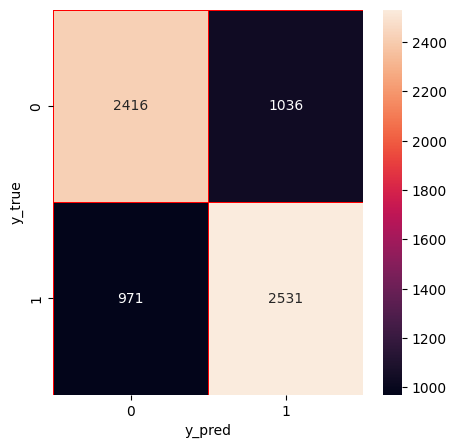

Classification report:
               precision    recall  f1-score   support

       False       0.71      0.70      0.71      3452
        True       0.71      0.72      0.72      3502

    accuracy                           0.71      6954
   macro avg       0.71      0.71      0.71      6954
weighted avg       0.71      0.71      0.71      6954



============================== LogisticRegression Model Evaluation ==============================

Cross Validation Mean Score:
 0.7139785413048871

Model Accuracy:
 0.7188668392292206



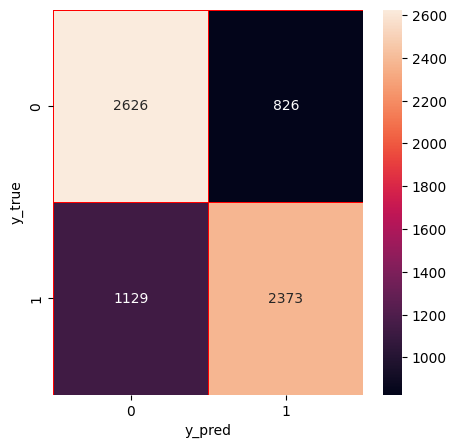

Classification report:
               precision    recall  f1-score   support

       False       0.70      0.76      0.73      3452
        True       0.74      0.68      0.71      3502

    accuracy                           0.72      6954
   macro avg       0.72      0.72      0.72      6954
weighted avg       0.72      0.72      0.72      6954



============================== Random Forest Model Evaluation ==============================

Cross Validation Mean Score:
 0.7870321673695526

Model Accuracy:
 0.999712395743457



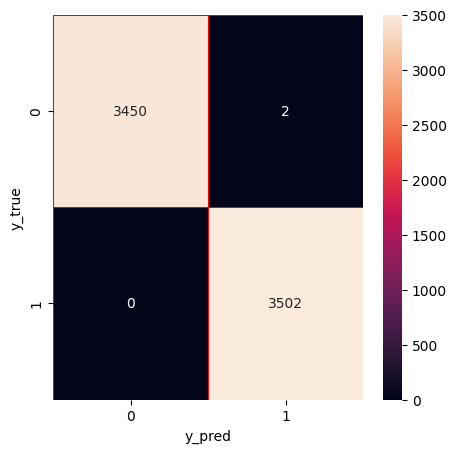

Classification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      3452
        True       1.00      1.00      1.00      3502

    accuracy                           1.00      6954
   macro avg       1.00      1.00      1.00      6954
weighted avg       1.00      1.00      1.00      6954



============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.7337550316273721



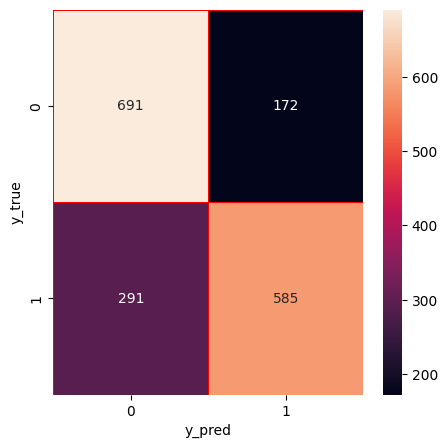


Classification report:
               precision    recall  f1-score   support

       False       0.70      0.80      0.75       863
        True       0.77      0.67      0.72       876

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.73      1739



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.7239792984473835



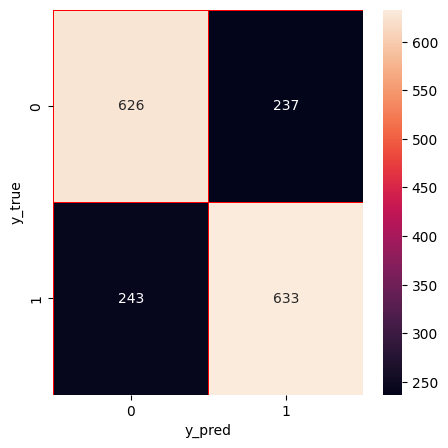


Classification report:
               precision    recall  f1-score   support

       False       0.72      0.73      0.72       863
        True       0.73      0.72      0.73       876

    accuracy                           0.72      1739
   macro avg       0.72      0.72      0.72      1739
weighted avg       0.72      0.72      0.72      1739



============================== KNeighborsClassifier Model Test Results ==============================

Model Accuracy:
 0.5123634272570443



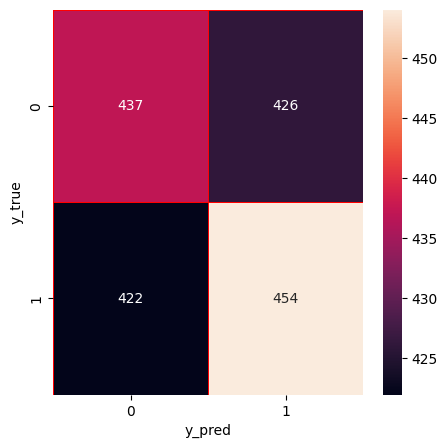


Classification report:
               precision    recall  f1-score   support

       False       0.51      0.51      0.51       863
        True       0.52      0.52      0.52       876

    accuracy                           0.51      1739
   macro avg       0.51      0.51      0.51      1739
weighted avg       0.51      0.51      0.51      1739



============================== LogisticRegression Model Test Results ==============================

Model Accuracy:
 0.721679125934445



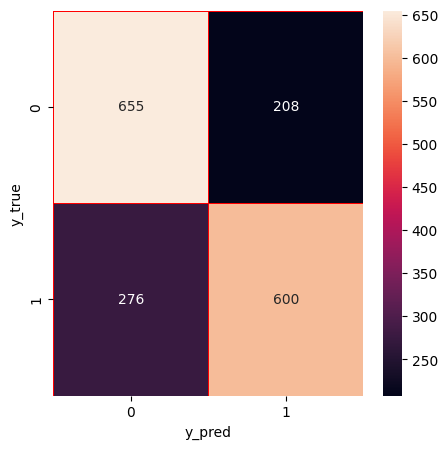


Classification report:
               precision    recall  f1-score   support

       False       0.70      0.76      0.73       863
        True       0.74      0.68      0.71       876

    accuracy                           0.72      1739
   macro avg       0.72      0.72      0.72      1739
weighted avg       0.72      0.72      0.72      1739



============================== Random Forest Model Test Results ==============================

Model Accuracy:
 0.7722829212190915



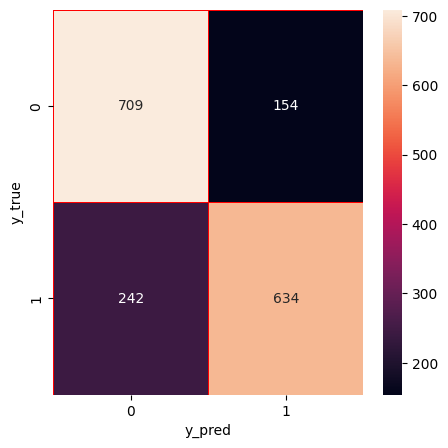


Classification report:
               precision    recall  f1-score   support

       False       0.75      0.82      0.78       863
        True       0.80      0.72      0.76       876

    accuracy                           0.77      1739
   macro avg       0.78      0.77      0.77      1739
weighted avg       0.78      0.77      0.77      1739




In [757]:
pipeline(X_train, X_test, y_train, y_test)